# Lab 8: Cluster Analysis

In this lab, you will utilize a 24-hour measurement of spatial accessibility in case the time-variant data was incorporated into the measurement. We name the spatial accessibility measurement investigated in the previous labs as **static measurement** and the 24-hour changes of spatial accessibility as **dynamic measurement**. 

<img src="./data/dyn_acc.jpg" style="width: 900px;"/>

The procedure of this lab. <br>
First, we employ **Pearson's correlation** coefficient to explore at which hour the static measurement fails to reflect the 24-hour dynamic measurement (i.e., when the correlation coefficient is low). <br>
Second, we want to temporally cluster the 24-hour variation based on their distribution characteristics (i.e., median and median absolute deviation). Here, we implement **K-means clustering** to overcome the verbose of 24-hour measurement. <br>

Data source: https://www.tandfonline.com/doi/full/10.1080/13658816.2021.1978450

### Notes:
**Before you submit your lab, make sure everything runs as expected WITHOUT ANY ERROR.** <br>
**Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`:**

In [1]:
FULL_NAME = ""

In [2]:
# Import necessary packages
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy
import numpy as np
import mapclassify
from matplotlib.colors import LinearSegmentedColormap

## 1. (0.5 point) Import Data

In this lab, you will be using the following two datasets. `dyn_acc` variable is the dynamic measurement, which represents spatial accessibility to EV charging stations every hour, and `static_acc` variable is the static measurement that doesn't consider the temporal changes of spatial accessibility to EV charging stations. 

**1.1.** Load `dynamic_access.shp` in the data folder as the name of `dyn_acc` with GeoPandas.<br>
**1.2.** Load `static_access.shp` in the data folder as the name of `static_acc` with GeoPandas.<br>

In [3]:
# Your code here
dyn_acc = gpd.read_file('./data/dynamic_access.shp')
static_acc = gpd.read_file('./data/static_access.shp')

Use the following two cells and investigate the structure of the GeoDataFrames.

In [4]:
dyn_acc.head(3)

,GRID_ID,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,geometry
0,BR-71,0.633759,0.627250,0.682185,0.650282,0.561308,0.607097,0.612872,0.913506,0.983909,...,1.448062,1.465338,2.142139,2.121508,3.070004,1.899256,1.001803,0.993266,0.845146,"POLYGON ((127.06100 37.43028, 127.05959 37.428..."
1,BT-71,0.442217,0.546755,0.555642,0.533923,0.425857,0.490122,0.386290,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.271575,0.315365,"POLYGON ((127.06947 37.43031, 127.06807 37.428..."
2,BP-70,0.182619,0.354411,0.312692,0.313881,0.186174,0.313370,0.163817,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077847,0.182723,"POLYGON ((127.05250 37.43415, 127.05109 37.432..."


In [5]:
static_acc.head(3)

,GRID_ID,static,geometry
0,BR-71,0.986563,"POLYGON ((127.06100 37.43028, 127.05959 37.428..."
1,BT-71,0.892418,"POLYGON ((127.06947 37.43031, 127.06807 37.428..."
2,BP-70,0.599535,"POLYGON ((127.05250 37.43415, 127.05109 37.432..."


## 2. (1 point) Pearson's correlation coefficient

Use Pearson's correlation coefficient (i.e., `pearsonr()` function) and investigate the correlation between the measure of accessibility at each hour and the static accessibility. If the correlation coefficient is **high and closed to 1**, it proves the static accessibility measurement and the dynamic accessibility at the specific hour is **similar**. This means that the static measurement can be used to estimate the accessibility at a certain hour. <br>
**However**, if the correlation coefficient is **low**, this means that the conventional static measurement **fails to estimate** the accessibility at a certain hour. 

**2.1.** Create a for loop that iterates through the hours from `0` to `23`. <br>
**2.2.** Calculate the correlation coefficient of each hour in `dyn_acc` and the static measurement in `static_acc`. <br>
**2.3.** If the correlation coefficient is statistically significant, append the resulted correlation coefficient to the list `corr_list`. If not, append `0` to the list `corr_list`. <br>
**2.4.** The populated `corr_list` will have the list of correlation coefficients with the order of hours from 0 to 23. 

In [6]:
# Your code here
corr_list = []

for h in range(24):
    temp_corr = pearsonr(static_acc['static'], dyn_acc[f'hour_{h}'])
    if temp_corr[1] < 0.05:
        corr_list.append(temp_corr[0])
    else:
        corr_list.append(0)
    
corr_list

[0.9341981515905738,
 0.9703715657302437,
 0.973075987964206,
 0.9718114188770557,
 0.9698892285831424,
 0.9651099097565202,
 0.9808073244179939,
 0.8020383566458209,
 0.6520010074365464,
 0.6585192118086818,
 0.6789526139294028,
 0.6505824808030044,
 0.6396028560214814,
 0.6462178790726385,
 0.5881207311230067,
 0.5387351627390503,
 0.534586079714711,
 0.4788444263157302,
 0.36904939619100874,
 0.29447913867105563,
 0.5549633342544716,
 0.7273911641346937,
 0.7720302010203794,
 0.846145916117677]

In [7]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""

assert round(corr_list[0], 3) == 0.934
assert round(corr_list[6], 3) == 0.981
assert round(corr_list[12], 3) == 0.64
assert round(corr_list[18], 3) == 0.369
assert round(corr_list[21], 3) == 0.727

print('Success!')

Success!


**2.5.** Create a line graph that has 24 hours as the x-axis and correlation coefficient as the y-axis. <br>
**2.6.** Use a `print()` function and print the hour of the lowest correlation coefficient and its correlation coefficient. 

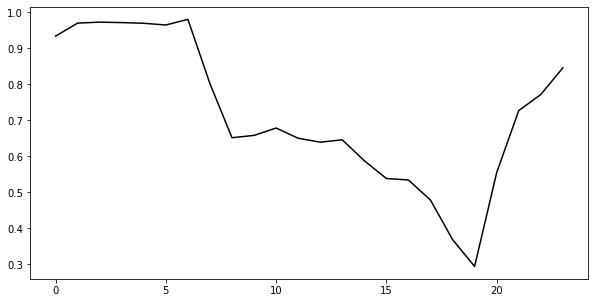

Hour: 19, Corr coef: 0.29447913867105563


In [8]:
# Your code here
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(list(range(0, 24)), corr_list, color='black')
plt.show()

print(f'Hour: {corr_list.index(min(corr_list))}, Corr coef: {min(corr_list)}')

## 3. (2.5 points) K-Means clustering for temporal clustering

We now know that the temporal changes embedded in 24-hour spatial accessibility measurement are pretty significant. Therefore, we want to temporally cluster the hourly measurement into a few temporal groups so that we can see their distinctive temporal changes. 
<br>

BEFORE CLUSTERING | AFTER CLUSTERING
:-: | :-:
![alt](./data/scatter_before_cluster.png) | ![alt](./data/scatter_after_cluster.png)

### 3.1. (1 point) Place the accessibility of each hour into a two-dimensional plane

First, we need to place the accessibility of each hour into a two-dimensional plane based on their representative value, median, and median absolute deviation. <br>

**3.1.1.** Create a `for-loop` that iterates through the hours from `0` to `23`. <br>
**3.1.2.** Calculate the median of accessibility at each hour with <a href=https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.median.html>`pandas.DataFrame.median()`</a> function, and append the result to `median_acc` list. <br>
**3.1.3.** Calculate the median absolute deviation of accessibility at each hour with <a href=https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mad.html>`pandas.DataFrame.mad()`</a> function and append the result to `mad_acc` list. <br>

In [9]:
median_acc = []  # Median accessibility of each hour
mad_acc = []  # Median absolute deviation of the accessibility each hour

# Your code here
for h in range(24):
    median_acc.append(dyn_acc[f'hour_{h}'].median())
    mad_acc.append(dyn_acc[f'hour_{h}'].mad())


Now, we will incorporate the two lists into a DataFrame `summary_df`. 

**3.1.4.** Create a column `hours` in the `summary_df` DataFrame. <br>
**3.1.5.** Create a column `median` in the `summary_df` DataFrame, and populate the column with `median_acc` list. <br>
**3.1.6.** Create a column `mad` in the `summary_df` DataFrame, and populate the column with `mad_acc` list. <br>

The following is the expected result of the `summary_df` DataFrame. 

<img src="./data/summary_df.jpg" style="width: 200px;"/>

In [10]:
summary_df = pd.DataFrame()

# Your code here
summary_df['hours'] = [h for h in range(24)]
summary_df['median'] = median_acc
summary_df['mad'] = mad_acc
summary_df.head()

,hours,median,mad
0,0,3.518847,1.154020
1,1,3.586415,1.052632
2,2,3.594756,1.055346
3,3,3.581439,1.069166
4,4,3.578939,1.072065


In [11]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""

assert ('hours' in summary_df.columns) & ('median' in summary_df.columns) & ('mad' in summary_df.columns)
assert summary_df.at[7, 'median'].round(4) == 3.3287
assert summary_df.at[7, 'mad'].round(4) == 1.5143
assert summary_df.at[19, 'mad'].round(4) == 2.4524
assert summary_df.at[19, 'median'].round(4) == 3.3014

print('Success!')

Success!


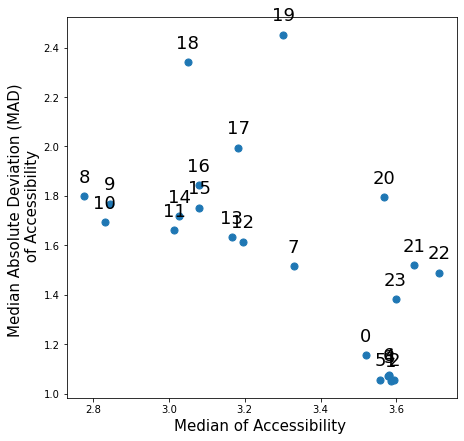

In [12]:
""" Check your answer here. This cell should show a figure that looks the same as `BEFORE CLUSTERING` above."""

fig, ax = plt.subplots(figsize=(7, 7))

# Place the accessibility measures of each hour on a two-dimensional plane 
ax.scatter(summary_df['median'], summary_df['mad'], s = 50)

# Create label of axis
ax.set_ylabel(f'Median Absolute Deviation (MAD) \n of Accessibility', rotation='vertical', fontsize=15)
ax.set_xlabel('Median of Accessibility ', fontsize=15)

# Annotate the representative value of each hour accessibility measurement
for t in range(24):
    ax.annotate(text=f'{t}',
                xy=(summary_df.loc[summary_df['hours'] == t, 'median'], 
                    summary_df.loc[summary_df['hours'] == t, 'mad']
                   ),
                textcoords = 'offset points',
                xytext=(0, 14),
                ha='center',
                size=18
               )
plt.show()


### 3.2. (0.5 point) K-Means: Allocate observations into three clusters

You are about to group the hours in `summary_df` into **three clusters** based on the `median` and `mad` of accessibility at each hour. 

**3.2.1.** Initiate K-Means clustering process with <a href=https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html>`KMeans()`</a> function. Use the number `3` as the number of clusters (`n_clusters`) and assign the result as variable `kmeans_result`. <br>
**3.2.2.** Call <a href=https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit>`fit()`</a> function of the KMeans instance `kmeans_result`. Feed the function with `median` and `mad` columns in `summary_df`. <br>
**3.2.3.** Investigate the clustering result in `.labels_` attribute of the KMeans instance `kmeans_result`. Assign the clustering result as `cluster` column of `summary_df`. <br>
**3.2.4.** Assign the color of each clutsr as `color` column in `summary_df` DataFrame, based on `colors` list below.<br>
```python

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']

```
**Note** Given that the K-means is simulation-based, the cluster label will be different for each try. But, the set of observations associated with a certain label will remain the same. <br>

The expected result of this task looks like the below.
<img src="./data/k_means_3.jpg" style="width: 300px;"/>



In [13]:
# Initiate KMeans instance
kmeans_result = KMeans(n_clusters=3)

# Feed the observation into the KMeans instance and conduct clustering
kmeans_result.fit(summary_df[['median', 'mad']])

# Assign the clustering result back to `summary_df` DataFrame. 
summary_df['cluster'] = kmeans_result.labels_

# Assign the color based on the clustering result
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
summary_df['color'] = summary_df.apply(lambda x:colors[int(x['cluster'])], axis=1)
summary_df.head()

,hours,median,mad,cluster,color
0,0,3.518847,1.154020,1,#1f78b4
1,1,3.586415,1.052632,1,#1f78b4
2,2,3.594756,1.055346,1,#1f78b4
3,3,3.581439,1.069166,1,#1f78b4
4,4,3.578939,1.072065,1,#1f78b4


In [14]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""

assert len(summary_df['cluster'].unique()) == 3
assert summary_df.loc[summary_df['hours'] == 18, 'cluster'].values[0] == summary_df.loc[summary_df['hours'] == 19, 'cluster'].values[0]
assert summary_df.loc[summary_df['hours'] == 17, 'cluster'].values[0] == summary_df.loc[summary_df['hours'] == 20, 'cluster'].values[0]

print('Success!')

Success!


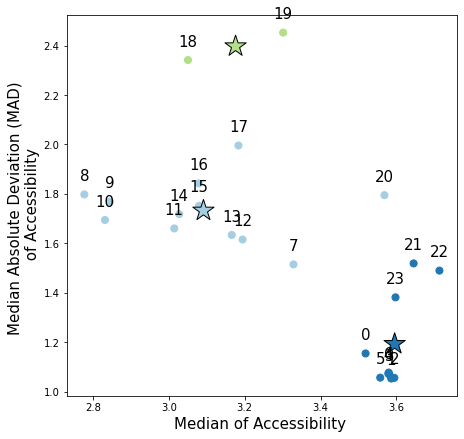

In [15]:
""" Check your answer here. This cell should show three clusters."""
fig, ax = plt.subplots(figsize=(7, 7))

# Place the accessibility measures of each hour on a two-dimensional plane 
ax.scatter(summary_df['median'], summary_df['mad'], s = 50, c=summary_df['color'])

# Place the center of each cluster
ax.scatter(kmeans_result.cluster_centers_.transpose()[0], 
           kmeans_result.cluster_centers_.transpose()[1], 
           color=colors[0: len(kmeans_result.cluster_centers_)], 
           s=500,
           marker='*',
           edgecolors='black'
          )

# Create label of axis
ax.set_ylabel(f'Median Absolute Deviation (MAD) \n of Accessibility', rotation='vertical', fontsize=15)
ax.set_xlabel('Median of Accessibility ', fontsize=15)

# Annotate the representative value of each hour accessibility measurement
for t in range(24):
    ax.annotate(text=f'{t}',
                xy=(summary_df.loc[summary_df['hours'] == t, 'median'], 
                    summary_df.loc[summary_df['hours'] == t, 'mad']
                   ),
                textcoords = 'offset points',
                xytext=(0, 14),
                ha='center',
                size=15
               )


### 3.3. (0.5 point) Find the optimal number of clusters with the Silhouette method

The quality of clustering is indicated by the number of clusters (i.e. K) as a direct correlation. Therefore, we need to find the optimal number of clusters. The following function `determine_number_of_cluster` can take DataFrame or Array as inputs and will provide the Silhouette scores based on the current partitioning with the cluster number `i`. 
```python
def determine_number_of_cluster(array):
    km_silhouette = []

    # The number of clusters 
    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999)  # Initiate KMeans instance
        KM.fit(array)  # Feed the observation into the KMeans instance and conduct clustering
        cluster_results = KM.labels_  # Clustering results
        silhouette = silhouette_score(array, cluster_results) # Calculate Silhouette Scores
        km_silhouette.append(silhouette)

    return km_silhouette
```


**3.3.1.** Feed `determine_number_of_cluster()` with `median` and `mad` columns in `summary_df`. Save the result as `k_means_silhouette`. <br>
**3.3.2.** Create a line graph that has the number of clusters as the x-axis and silhouette score as the y-axis.<br>
**3.3.3.** Use a `print()` function and print the number of cluster that provides the highest silhouette score, which indicates the optimal number of clusters. 

**Note**: Silhouette scores are only available from cluster count **2** and more. 

In [16]:
def determine_number_of_cluster(array):
    km_silhouette = []

    # The number of clusters 
    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999)  # Initiate KMeans instance
        KM.fit(array)  # Feed the observation into the KMeans instance and conduct clustering
        cluster_results = KM.labels_  # Clustering results
        silhouette = silhouette_score(array, cluster_results) # Calculate Silhouette Scores
        km_silhouette.append(silhouette)

    return km_silhouette

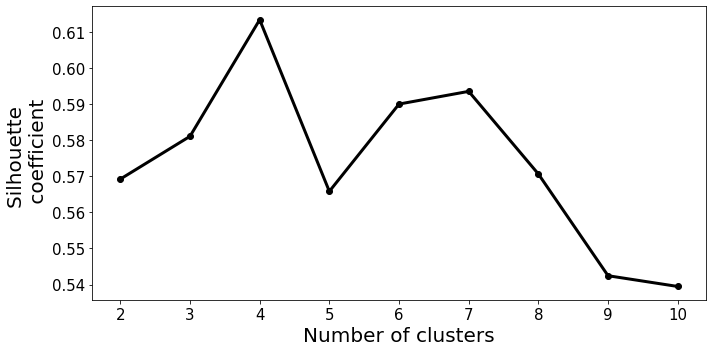

Cluster Count: 4, Silhouette Score: 0.61343865788211


In [17]:
# Your code here
k_means_silhouette = determine_number_of_cluster(summary_df[['median', 'mad']])

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(range(2, 11), k_means_silhouette, color='black', linewidth='3', marker='o', linestyle='solid')

ax.set_ylabel(f'Silhouette \n coefficient', rotation='vertical', fontsize=20)
ax.set_xlabel('Number of clusters', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

print(f'Cluster Count: {k_means_silhouette.index(max(k_means_silhouette)) + 2}, Silhouette Score: {max(k_means_silhouette)}')

In [18]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""

assert round(k_means_silhouette[0], 3) == 0.569
assert round(k_means_silhouette[2], 3) == 0.613
assert round(k_means_silhouette[7], 3) == 0.542

print('Success!')

Success!


### 3.4. (0.5 point) Update K-means clustering result with the optimal number of clusters

Now we know that `4` clusters are optimal for our temporal clustering implementation. Update `cluster` and `color` column of `summary_df` based on the number of clusters 4. 

**3.4.1.** (0.2 point) Initiate K-Means clustering process with <a href=https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html>`KMeans()`</a> function. Use the number `4` as the number of clusters (`n_clusters`) and assign the result as variable `kmeans_optimal`. <br>
**3.4.2.** Call <a href=https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit>`fit()`</a> function of the KMeans instance `kmeans_optimal`. Feed the function with `median` and `mad` columns in `summary_df`. <br>
**3.4.3.** Investigate the clustering result in `.labels_` attribute of the KMeans instance `kmeans_optimal`. Assign the clustering result as `cluster` column of `summary_df`. <br>
**3.4.4.** Assign the color of each clutsr as `color` column in `summary_df` DataFrame, based on `colors` list below.<br>
```python

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']

```
The expected result of this task looks like the below (Contents of the DataFrame below may be different from your implementation).
<img src="./data/k_means_3.jpg" style="width: 300px;"/>

In [19]:
# Your code here
# Initiate KMeans instance
kmeans_optimal = KMeans(n_clusters=4)

# Feed the observation into the KMeans instance and conduct clustering
kmeans_optimal.fit(summary_df[['median', 'mad']])

# Assign the clustering result back to `summary_df` DataFrame. 
summary_df['cluster'] = kmeans_optimal.labels_

# Assign the color based on the clustering result
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
summary_df['color'] = summary_df.apply(lambda x:colors[x['cluster']], axis=1)
summary_df

,hours,median,mad,cluster,color
0,0,3.518847,1.154020,1,#1f78b4
1,1,3.586415,1.052632,1,#1f78b4
2,2,3.594756,1.055346,1,#1f78b4
3,3,3.581439,1.069166,1,#1f78b4
4,4,3.578939,1.072065,1,#1f78b4
5,5,3.557555,1.056159,1,#1f78b4
6,6,3.579902,1.076723,1,#1f78b4
7,7,3.328706,1.514323,3,#33a02c
8,8,2.776896,1.797429,0,#a6cee3
9,9,2.844621,1.768021,0,#a6cee3


In [20]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""

assert len(summary_df['cluster'].unique()) == 4
assert summary_df.loc[summary_df['hours'] == 18, 'cluster'].values[0] == summary_df.loc[summary_df['hours'] == 19, 'cluster'].values[0]
assert summary_df.loc[summary_df['hours'] == 17, 'cluster'].values[0] != summary_df.loc[summary_df['hours'] == 20, 'cluster'].values[0]

print('Success!')

Success!


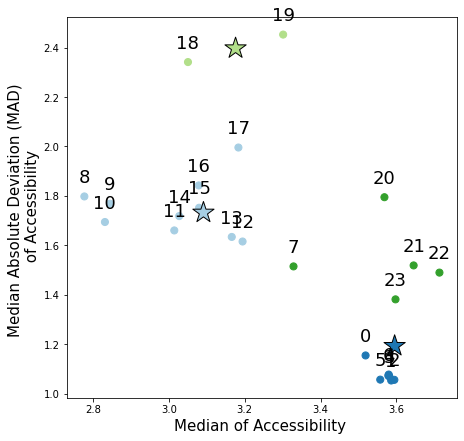

In [21]:
""" Check your answer here. This cell should show four clusters."""

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(summary_df['median'], summary_df['mad'], s = 50, c=summary_df['color'])

ax.scatter(kmeans_result.cluster_centers_.transpose()[0], 
           kmeans_result.cluster_centers_.transpose()[1], 
           color=colors[0: len(kmeans_result.cluster_centers_)], 
           s=500,
           marker='*',
           edgecolors='black'
          )

ax.set_ylabel(f'Median Absolute Deviation (MAD) \n of Accessibility', rotation='vertical', fontsize=15)
ax.set_xlabel('Median of Accessibility ', fontsize=15)


for t in range(24):
    ax.annotate(text=f'{t}',
                xy=(summary_df.loc[summary_df['hours'] == t, 'median'], 
                    summary_df.loc[summary_df['hours'] == t, 'mad']
                   ),
                textcoords = 'offset points',
                xytext=(0, 14),
                ha='center',
                size=18
               )

plt.show()

## 4. (1 point) Temporally clustered 24-hour spatial accessibility

As we know which hour is associated with which temporal cluster, we now move on to make maps of temporally clustered accessibility.

**4.1.** Find which hour is associated with a certain cluster, based on the `cluster` and `hours` columns of `summary_df` DataFrame. <br>
**4.2.** Calculate the average of accessibility based on the hours associated with each temporal cluster. For example, suppose cluster 0 has the hours 0, 1, and 2. You will calculate the average of the accessibility measured at hours 0, 1, and 2 for every location. <br> 
**4.3.** Enter the averaged measures of spatial accessibility to `dyn_acc_plot` GeoDataFrame, which is a copy of `dyn_acc` GeoDataFrame and only has `geometry` column. The averaged measures will have its name as `kmeans_c0`, `kmeans_c1`, `kmeans_c2`, and `kmeans_c3`. Again, the order of the number can be different. <br>

The final product should look like the below. 

<img src="./data/cluster_gdf.jpg" style="width: 700px;"/>

In [22]:
# Your code here
dyn_acc_plot = dyn_acc[['geometry']].copy()

for cluster_num in summary_df['cluster'].unique():
    associated_hours = summary_df.loc[summary_df['cluster'] == cluster_num, 'hours'].values
    
    print(cluster_num, associated_hours)
    dyn_acc_plot[f'kmeans_c{cluster_num}'] = dyn_acc.loc[:,[f'hour_{t}' for t in associated_hours]].mean(axis=1)
    
dyn_acc_plot

1 [0 1 2 3 4 5 6]
3 [ 7 20 21 22 23]
0 [ 8  9 10 11 12 13 14 15 16 17]
2 [18 19]


,geometry,kmeans_c1,kmeans_c3,kmeans_c0,kmeans_c2
0,"POLYGON ((127.06100 37.43028, 127.05959 37.428...",0.624965,1.130595,1.349649,2.595756
1,"POLYGON ((127.06947 37.43031, 127.06807 37.428...",0.482972,0.117388,0.000000,0.000000
2,"POLYGON ((127.05250 37.43415, 127.05109 37.432...",0.260995,0.052114,0.000000,0.000000
3,"POLYGON ((127.05675 37.43222, 127.05534 37.430...",0.444657,0.913440,0.951304,1.963963
4,"POLYGON ((127.06097 37.43418, 127.05957 37.432...",0.624965,1.130595,1.349649,2.595756
...,...,...,...,...,...
698,"POLYGON ((127.11980 37.53587, 127.11840 37.533...",1.587714,1.598102,1.118167,1.470812
699,"POLYGON ((127.12406 37.53393, 127.12265 37.531...",2.475607,2.023380,1.319773,1.610897
700,"POLYGON ((127.11555 37.53780, 127.11414 37.535...",2.660404,2.463269,0.764069,0.659779
701,"POLYGON ((127.11978 37.53977, 127.11838 37.537...",0.927177,0.454658,0.322587,0.000000


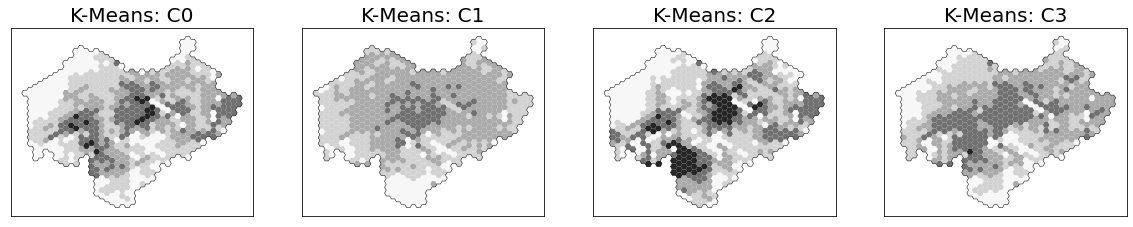

In [23]:
""" 
Check your answer here. This cell will demonstrate how the temporally clustered accessibility look like. 
If there are four maps with the name of K-means: C0, C1, C2, and C3, and 
each map has different distribution of accessibility, You are good to go.  
"""

color_map = ['#f7f7f7', '#d9d9d9', '#bdbdbd', '#969696', '#636363', '#252525']
cm = LinearSegmentedColormap.from_list('cb_', color_map, N=5)

map_class = mapclassify.FisherJenks(dyn_acc[[f'hour_{t}' for t in range(24)]], k=5)

fig, axes = plt.subplots(1, 4, figsize=(20, 8))

for idx, ax in enumerate(axes):
    dyn_acc_plot.plot(f'kmeans_c{idx}', 
                      scheme='user_defined', # To use different (not predefined) bins, we need to call it as 'user_defined'
                      classification_kwds={'bins':map_class.bins}, # then speicfy class here. 
                      cmap=cm,
                      ax=ax
                     )
    ax.set_title(f'K-Means: C{idx}', size=20)
    
    gpd.GeoSeries(dyn_acc_plot.unary_union, crs='EPSG:4326').boundary.plot(color='black', ax=ax, linewidth=0.5)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### *You have finished Lab 8: Cluster Analysis*

Please name your jupyter notebook as `GEOG489_Lab8_[YOUR_NET_ID].ipynb`, and upload it to https://learn.illinois.edu.